# Chapter 10 - Portfolio theory - envelope portfolios
---

In [1]:
# Preamble
import pandas as pd
import numpy as np
import os # To set our working folder
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen as uReq
import urllib.error as uErr
import re
import tenacity
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
import seaborn as sns
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from linearmodels.panel import PanelOLS
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

if os.name=='nt':
    import xlwings as xw


@tenacity.retry(wait=tenacity.wait_exponential(multiplier=1, min=4, max=64), stop=tenacity.stop_after_attempt(5))
def get_that_page(url):
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        uClient = uReq(req)
        print('Success')
    except Exception:
        print('Trying again.')
    return uClient


def do_table(url):
    uClient = get_that_page(url)
    soup = BeautifulSoup(uClient, 'lxml')
    table = soup.find('table', class_='instruments-table')
    table_headers =[]
    for tx in soup.find_all('th'):
        table_headers.append(tx.get('id'))

    filler = ['unknown', 'pct']
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        #print(cols)
        if len(cols)>0:
            data.append(cols)
    df = pd.DataFrame(data, columns=[x if x!=None else filler.pop() for x in table_headers])
    lyst = ['price', 'volume', 'value', 'outstanding_capitalisation', 'market_capitalisation', 'pct', 'trade_count']
    df[lyst] = df[lyst].replace({'\$': '', ',': ''}, regex=True).apply(pd.to_numeric,  errors='coerce')
    df['green_bond']= df['green_bond'].map({'false': 0, 'true': 1})
    df = df[~df['company'].str.contains('Smartshares')]
    df['code'] = df['code']+".NZ"
    nzx = df['code'].to_list()

    return(df[df['market_capitalisation']>0], nzx)


def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left =  lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)


def nice_print(df, k=1, name=""):
    if isinstance(df, pd.DataFrame):
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))
    elif isinstance(df, pd.Series):
        df.name= name
        df=df.to_frame()
        print(tabulate(k*df, tablefmt="fancy_grid", floatfmt=".4f", headers="keys"))


dfm, nzx  = do_table('https://www.nzx.com/markets/NZSX')

Success


In [2]:
def returns(nzx, start, end):
    dfy = yf.download(nzx, start, end, progress=True, interval="1mo")
    df_close = dfy['Adj Close'].copy()
    df_close.dropna(how = 'all', inplace=True, axis = 1)
    df_close.sort_index(inplace=True)
    #df_close.dropna(how='all').pct_change().add(1).cumprod().mean(axis=1).sub(1).plot()
    df_close.index = pd.to_datetime(df_close.index, format ='%Y-%m-%d')
    df_close.columns = [re.sub(r'.NZ$|\^', "", x) for x in list(df_close)]
    return list(df_close), df_close.resample('M').last()

nzx_set, df_close = returns(nzx+['^NZ50'], '2011-10-01', '2022-04-30')

[*********************100%***********************]  152 of 152 completed

10 Failed downloads:
- NTLOB.NZ: No data found, symbol may be delisted
- BIT.NZ: No data found for this date range, symbol may be delisted
- KFLWG.NZ: No data found, symbol may be delisted
- FCT.NZ: No data found for this date range, symbol may be delisted
- AKL.NZ: No data found, symbol may be delisted
- CO2.NZ: No data found for this date range, symbol may be delisted
- PLP.NZ: No data found for this date range, symbol may be delisted
- MLNWE.NZ: No data found, symbol may be delisted
- BIF.NZ: No data found for this date range, symbol may be delisted
- JPG.NZ: No data found for this date range, symbol may be delisted


In [3]:
df_close.shape

(127, 142)

### Building a portfolio of multiple stocks

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

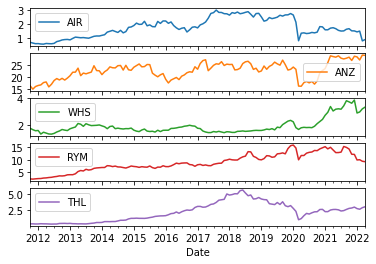

In [4]:
stocks_list = ["AIR", "ANZ", 'WHS', 'RYM', 'THL']
data = df_close[stocks_list]
data.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

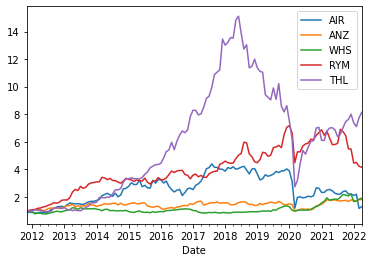

In [5]:
# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
monthly_ret.cumsum().apply(np.exp).plot()

In [6]:
# Variance Covariance Matrix
dfs = monthly_ret[stocks_list].cov()
dfs

,AIR,ANZ,WHS,RYM,THL
AIR,0.018886,0.003304,0.001627,0.004902,0.008165
ANZ,0.003304,0.004616,0.000925,0.001561,0.003030
WHS,0.001627,0.000925,0.004181,0.001751,0.001330
RYM,0.004902,0.001561,0.001751,0.005237,0.003343
THL,0.008165,0.003030,0.001330,0.003343,0.012189


In [7]:
# Input: mean returns
dfr = monthly_ret[stocks_list].mean()#*12
dfr.name= 'Returns'
dfr

AIR    0.002013
ANZ    0.004614
WHS    0.005076
RYM    0.011274
THL    0.016631
Name: Returns, dtype: float64

In [8]:
sigma = pd.Series(np.diag(dfs)**.5, name = 'Sigma', index= stocks_list)
sigma = sigma.astype(float)
sigma

AIR    0.137428
ANZ    0.067942
WHS    0.064662
RYM    0.072369
THL    0.110405
Name: Sigma, dtype: float64

<AxesSubplot:>

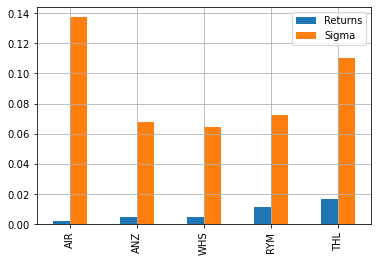

In [9]:
dfr.to_frame().join(sigma).plot(kind='bar',grid=True,table=False,legend=True)

---

**Create portfolio with arbitrary weights**

---

AIR    0.2
ANZ    0.3
WHS    0.3
RYM    0.1
THL    0.1
Name: x_wei, dtype: float64


<AxesSubplot:title={'center':'Weights of portfolio X'}>

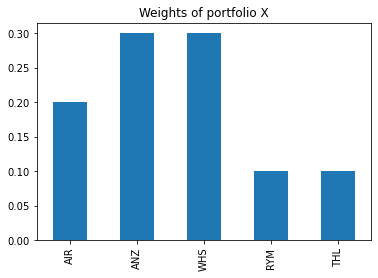

In [10]:
# Input: Portfolio weights
port_x_prop = pd.Series(np.array([0.2, 0.3, 0.3, 0.1, 0.1]), index=dfs.index, name= 'x_wei')
print(pd.Series(port_x_prop))
port_x_prop.plot(kind='bar', title='Weights of portfolio X' )

AIR    0.1
ANZ    0.1
WHS    0.1
RYM    0.1
THL    0.6
Name: y_wei, dtype: float64


<AxesSubplot:title={'center':'Weights of portfolio Y'}>

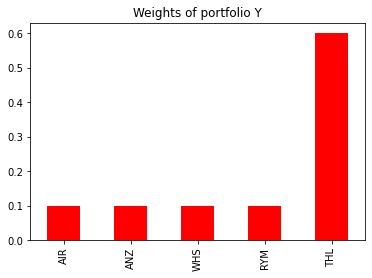

In [11]:
port_y_prop = pd.Series(np.array([0.1, 0.1, 0.1, 0.1, 0.6]), index=dfs.index, name= 'y_wei')
print(pd.Series(port_y_prop))
port_y_prop.plot(kind='bar', color='r', title='Weights of portfolio Y' )

In [12]:
# Portfolios Mean Returns

port_x_ret = dfr @ port_x_prop
port_y_ret = dfr @ port_y_prop

nice_print(pd.Series([port_x_ret, port_y_ret], index=['X','Y']), name = "Mean Returns")

╒════╤════════════════╕
│    │   Mean Returns │
╞════╪════════════════╡
│ X  │         0.0061 │
├────┼────────────────┤
│ Y  │         0.0123 │
╘════╧════════════════╛


In [13]:
# Portfolios Variance
port_x_var = port_x_prop @ dfs @ port_x_prop
port_y_var = port_y_prop @ dfs @ port_y_prop
nice_print(pd.Series([port_x_var,port_y_var],index=['X','Y']), name = "Portfolios Variance")

╒════╤═══════════════════════╕
│    │   Portfolios Variance │
╞════╪═══════════════════════╡
│ X  │                0.0035 │
├────┼───────────────────────┤
│ Y  │                0.0069 │
╘════╧═══════════════════════╛


In [14]:
# Covarinace(X,Y)
cov_xy = port_x_prop @ dfs @ port_y_prop
nice_print(pd.Series(cov_xy,index=["Cov(X,Y)"]))

╒══════════╤════════╕
│          │        │
╞══════════╪════════╡
│ Cov(X,Y) │ 0.0041 │
╘══════════╧════════╛


In [15]:
# Portfolios Standard Deviations
port_x_sigma = port_x_var**.5
port_y_sigma = port_y_var**.5

nice_print(pd.Series([port_x_sigma, port_y_sigma],index=['X','Y']), name = "Portfolios Sigma")

╒════╤════════════════════╕
│    │   Portfolios Sigma │
╞════╪════════════════════╡
│ X  │             0.0594 │
├────┼────────────────────┤
│ Y  │             0.0831 │
╘════╧════════════════════╛


In [16]:
# Correlation Coefficient (X,Y)
nice_print(pd.Series(cov_xy / (port_x_sigma * port_y_sigma),index=["Rho"]), name = "Correlation Coefficient")

╒═════╤═══════════════════════════╕
│     │   Correlation Coefficient │
╞═════╪═══════════════════════════╡
│ Rho │                    0.8369 │
╘═════╧═══════════════════════════╛


In [17]:
# Portfolio statistcis
dfp = pd.DataFrame([[port_x_ret, port_x_var, port_x_sigma],
                    [port_y_ret, port_y_var, port_y_sigma]],
             columns = ["Returns", "Variance", 'Sigma'],
             index = ['X', 'Y'])
nice_print(dfp.T)

╒══════════╤════════╤════════╕
│          │      X │      Y │
╞══════════╪════════╪════════╡
│ Returns  │ 0.0061 │ 0.0123 │
├──────────┼────────┼────────┤
│ Variance │ 0.0035 │ 0.0069 │
├──────────┼────────┼────────┤
│ Sigma    │ 0.0594 │ 0.0831 │
╘══════════╧════════╧════════╛


In [18]:
### Envelope Portfolios
# Portfolio Z is a portfolio constructed of portfolio X and portfolio Y.

Xa = 0.3
# port_z_weights = np.array([Xa, 1-Xa]).T
port_z_weights = pd.Series([Xa, 1-Xa],index=['X','Y'])

port_z_returns = pd.Series([port_x_ret, port_y_ret],index=['X','Y'])

# Portfolio X Returns
port_z_ret = port_z_weights @ port_z_returns

# Portfolio Variance
port_z_var =    port_z_weights.loc['X']**2 * port_x_var + port_z_weights.loc['Y']**2 * port_y_var + 2 * np.prod(port_z_weights) * cov_xy

# Portfolios Sigma
port_z_sigma = port_z_var**.5

In [19]:
nice_print(port_z_weights, name= 'Z_weights')
nice_print(port_z_returns, name= 'Z_returns')

print('\nport_z_ret:   {:2.4}'.format(port_z_ret))
print('\nport_z_var:   {:2.4}'.format(port_z_var))
print('\nport_z_sigma: {:2.4}'.format(port_z_sigma))

╒════╤═════════════╕
│    │   Z_weights │
╞════╪═════════════╡
│ X  │      0.3000 │
├────┼─────────────┤
│ Y  │      0.7000 │
╘════╧═════════════╛
╒════╤═════════════╕
│    │   Z_returns │
╞════╪═════════════╡
│ X  │      0.0061 │
├────┼─────────────┤
│ Y  │      0.0123 │
╘════╧═════════════╛

port_z_ret:   0.01042

port_z_var:   0.005435

port_z_sigma: 0.07372


<AxesSubplot:xlabel='Sigma'>

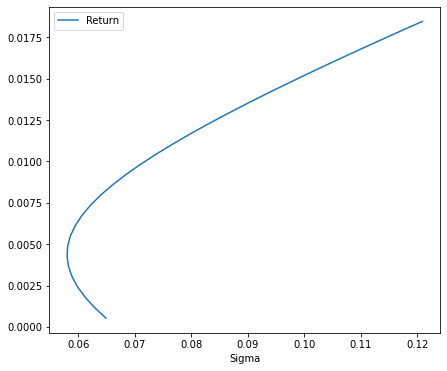

In [20]:
# Set an Array of Portfolio Weights
port_x_weight = np.arange(-1,2,0.1)
port_y_weight = 1-port_x_weight

# Portfolio Z Mean Returns
port_z_ret = port_x_weight * port_x_ret + port_y_weight * port_y_ret
#print(pd.Series(port_z_ret))

# Portfolios Sigma
port_z_sigma = (port_x_weight ** 2 * port_x_var + port_y_weight ** 2 * port_y_var + (port_x_weight * port_y_weight) * cov_xy * 2) ** 0.5
#print(pd.Series(port_z_sigma))

# Envelope
dfeff = pd.DataFrame({'Sigma': port_z_sigma, 'Return': port_z_ret}, columns=['Sigma', 'Return'])
dfeff.set_index('Sigma', inplace=True)
dfeff.plot(figsize=(7,6))

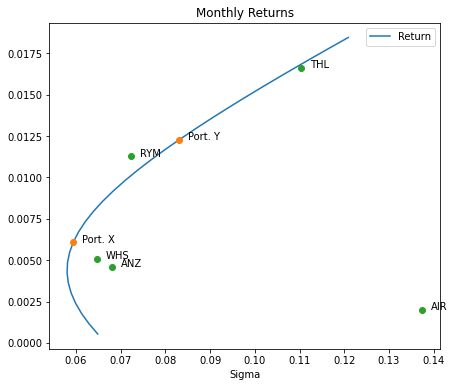

In [21]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title(r'Monthly Returns')
dfeff.plot(ax=ax)
assets_sigma = np.diag(dfs)**0.5
ax.plot([port_x_sigma, port_y_sigma], [port_x_ret, port_y_ret], 'o') # portfolios
ax.plot(assets_sigma, dfr, 'o') # assets
# Labels
ax.text(port_x_sigma+0.002,port_x_ret,'Port. X')
ax.text(port_y_sigma+0.002,port_y_ret,'Port. Y')

for x in list(range(0,5)):
    ax.text(assets_sigma[x]+0.002,dfr.iloc[x],dfr.index[x])